# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [107]:
import numpy as np
np.random.seed(0)

## Cargar y Limpieza de Datos

Se hace una lectura de las bases propuestas para el ejercicio y se procede a unir todas las bases para trabajar con un mismo conjunto de datos, luego se promedia el precio de la energia por día y se crea un campo 'year_month' el cual nos servira mas adelante para hacer un join.

Precio_Bolsa_Nacional_($kwh)_1995.xlsx
Precio_Bolsa_Nacional_($kwh)_1996.xlsx
Precio_Bolsa_Nacional_($kwh)_1997.xlsx
Precio_Bolsa_Nacional_($kwh)_1998.xlsx
Precio_Bolsa_Nacional_($kwh)_1999.xlsx
Precio_Bolsa_Nacional_($kwh)_2000.xlsx
Precio_Bolsa_Nacional_($kwh)_2001.xlsx
Precio_Bolsa_Nacional_($kwh)_2002.xlsx
Precio_Bolsa_Nacional_($kwh)_2003.xlsx
Precio_Bolsa_Nacional_($kwh)_2004.xlsx
Precio_Bolsa_Nacional_($kwh)_2005.xlsx
Precio_Bolsa_Nacional_($kwh)_2006.xlsx
Precio_Bolsa_Nacional_($kwh)_2007.xlsx
Precio_Bolsa_Nacional_($kwh)_2008.xlsx
Precio_Bolsa_Nacional_($kwh)_2009.xlsx
Precio_Bolsa_Nacional_($kwh)_2010.xlsx
Precio_Bolsa_Nacional_($kwh)_2011.xlsx
Precio_Bolsa_Nacional_($kwh)_2012.xlsx
Precio_Bolsa_Nacional_($kwh)_2013.xlsx
Precio_Bolsa_Nacional_($kwh)_2014.xlsx
Precio_Bolsa_Nacional_($kwh)_2015.xlsx
Precio_Bolsa_Nacional_($kwh)_2016.xls
Precio_Bolsa_Nacional_($kwh)_2017.xls
Precio_Bolsa_Nacional_($kwh)_2018.xls
longitud: 8486
longitud despues de eliminar na: 8405
Longitud despu

,fecha,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,promedio,year,month,day,year_month
0,1995-07-21,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,...,16.670,11.929,5.000,1.000,1.000,5.091783,1995,7,21,199507
1,1995-07-22,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,...,2.500,2.500,1.303,1.073,1.073,1.278043,1995,7,22,199507
2,1995-07-23,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,...,1.238,1.238,1.238,1.073,1.000,0.947870,1995,7,23,199507
3,1995-07-24,1,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,...,22.500,9.256,3.000,1.073,1.000,4.449652,1995,7,24,199507
4,1995-07-25,0.99,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,1.500,1.263,1.263,1.073,0.990,1.156087,1995,7,25,199507


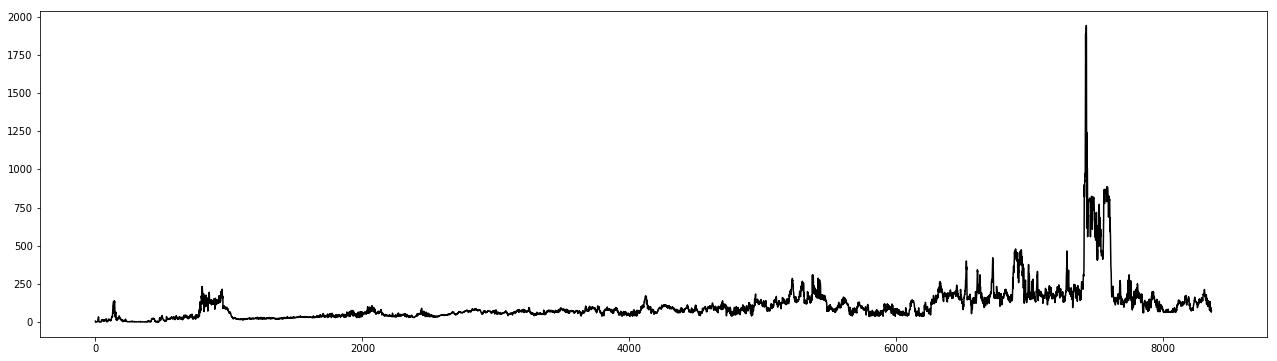

In [108]:
from os import scandir,getcwd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


DIR = 'datos/precios/'
archivos = scandir(DIR)
data = pd.DataFrame()
for archivo in archivos:
    print(archivo.name)
    auxdata = pd.read_excel(DIR + archivo.name,header=None,names=['fecha'] + [str(i)for i in range(1,25)]+['basura1']+['basura2'])
    data = pd.concat([data,auxdata])

    
data = data.drop(['basura1','basura2'],axis=1)
print('longitud:',len(data))
data = data.dropna()
print('longitud despues de eliminar na:',len(data))
data = data.drop(data[data['fecha']=='Fecha'].index)
print('Longitud despues de eliminar header fecha',len(data))
data = data.reset_index(drop=True)

#data.to_excel(DIR + 'precios.xlsx')
data['fecha']=data['fecha'].astype('datetime64[D]')

data['promedio'] = data.mean(axis=1)

data['year'] = data["fecha"].dt.strftime("%Y")
data['year'] = data['year'].astype('int')

data['month'] = data["fecha"].dt.strftime("%m")
data['month'] = data['month'].astype('int')

data['day'] = data["fecha"].dt.strftime("%d")
data['day'] = data['day'].astype('int')

data = data.sort_values(['year','month','day'],ascending = True)
data['year_month'] = data['year']*100  + data['month']
#data.head()

plt.figure(figsize=(22,6))
plt.plot(data['promedio'].values, color='black');
data.head()


## IPC

Para trabajar los precios sin tener en cuenta la inflación y poder reducirle complejidad al modelo, extraemos un historico de los IPC para colombia de la pagina .... luego hacemos un join con nuestra base de precios de energía por el campo 'year_month' que nos da la información del IPC mensual.

Luego se procede mediante una regla de 3 eliminar la inflación en los precios, tomando el IPC de 1995 como base.

$$Precio_i = Precio_i * \frac{IPC_{base}}{IPC_i}$$

,fecha,1,2,3,4,5,6,7,8,9,...,24,promedio,year,month,day,year_month,indice,inflacion_anual,inflacion_mensual,inflacion_año_corrido
0,1995-07-21,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,...,1.000,5,1995,7,21,199507,20.93,21.5,0.77,14.7
1,1995-07-22,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,...,1.073,1,1995,7,22,199507,20.93,21.5,0.77,14.7
2,1995-07-23,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,...,1.000,0,1995,7,23,199507,20.93,21.5,0.77,14.7
3,1995-07-24,1,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,...,1.000,4,1995,7,24,199507,20.93,21.5,0.77,14.7
4,1995-07-25,0.99,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,0.990,1,1995,7,25,199507,20.93,21.5,0.77,14.7


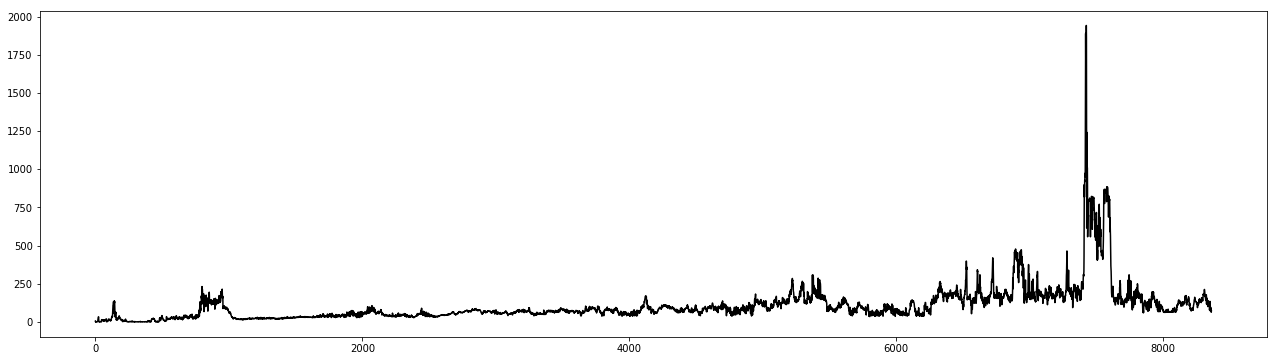

In [109]:
data_ipc = pd.read_excel('datos/ipc.xlsx',names=['fecha','indice','inflacion_anual','inflacion_mensual','inflacion_año_corrido'])
data_ipc = data_ipc.dropna()
data_ipc = data_ipc.drop(11)
data_ipc = data_ipc.sort_values(['fecha'],ascending = True)
data_ipc = data_ipc.reset_index(drop=True)
data_ipc['fecha'] = data_ipc['fecha'].astype('str')
data_ipc['year_month'] = data_ipc['fecha'].astype('int')
data_ipc = data_ipc.drop(['fecha'],axis=1)

data = pd.merge(data,data_ipc,on='year_month')
ipc_base = data['indice']
data['promedio'] = data['promedio']*ipc_base / data['indice']
data['promedio'] = data['promedio'].astype('int')

plt.figure(figsize=(22,6))
plt.plot(data['promedio'].values, color='black');
data.head()

In [110]:
base_data = data
base_data.head()

,fecha,1,2,3,4,5,6,7,8,9,...,24,promedio,year,month,day,year_month,indice,inflacion_anual,inflacion_mensual,inflacion_año_corrido
0,1995-07-21,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,...,1.000,5,1995,7,21,199507,20.93,21.5,0.77,14.7
1,1995-07-22,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,...,1.073,1,1995,7,22,199507,20.93,21.5,0.77,14.7
2,1995-07-23,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,...,1.000,0,1995,7,23,199507,20.93,21.5,0.77,14.7
3,1995-07-24,1,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,...,1.000,4,1995,7,24,199507,20.93,21.5,0.77,14.7
4,1995-07-25,0.99,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,0.990,1,1995,7,25,199507,20.93,21.5,0.77,14.7


## Implementación del Modelo

La implemetnación del modelo se hace con base en el codigo de clase sin ninguna modificación.

In [111]:
import numpy as np
import math
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

## Procesamiento de Datos

Varianza : 16599.75595284439
Varianza Logaritmica: nan
Varianza raiz cuadrada: 0.010102380934214858
Varianza raiz cubica: 0.011605124528692766
Varianza raiz cubica: 0.011071280997789278


C:\Users\ANDORREG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ANDORREG\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


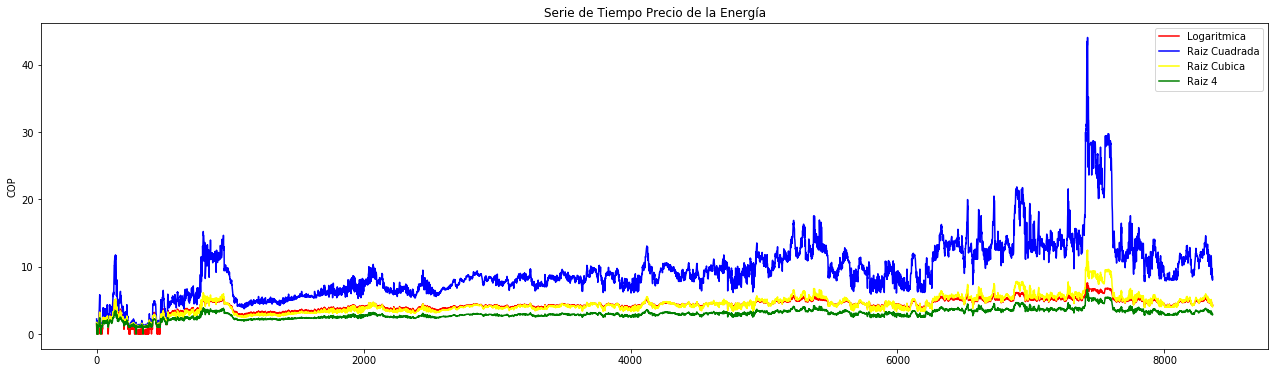

In [112]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


data = base_data['promedio']
data = np.array(data.values)
print('Varianza :',np.var(data))

#Logaritmica
log = np.log(data)
print('Varianza Logaritmica:',np.var(log/log.max()))

#Raiz cuadrada
rai2 = np.sqrt(data)
print('Varianza raiz cuadrada:',np.var(rai2/rai2.max()))

#Raiz cubica
rai3 = np.power(data,1/3)
print('Varianza raiz cubica:',np.var(rai3/rai3.max()))

#Raiz cuatro
rai4 = np.power(data,1/4)
print('Varianza raiz cubica:',np.var(rai4/rai4.max()))




plt.figure(figsize=(22,6))
plt.title('Serie de Tiempo Precio de la Energía')
plt.ylabel('COP')
#plt.plot(data, color='black',label='Original')
plt.plot(log, color='red',label='Logaritmica')
plt.plot(rai2, color='blue',label='Raiz Cuadrada')
plt.plot(rai3, color='yellow',label='Raiz Cubica')
plt.plot(rai4, color='green',label='Raiz 4')
plt.legend()
plt.show()

Luego de analisadas las distintas trasnformación, se descarta de primera la función logaritmica, ya que esta genera valores en cero que traen como consecuencias perdidas de información; Luego se analisan las tranformaciones de las raices y se puede ver que su forma no cambia, solo cambian su escala de datos, a partir de esto se procede a trabajar con la raiz cubica y se le aplica una normalización.

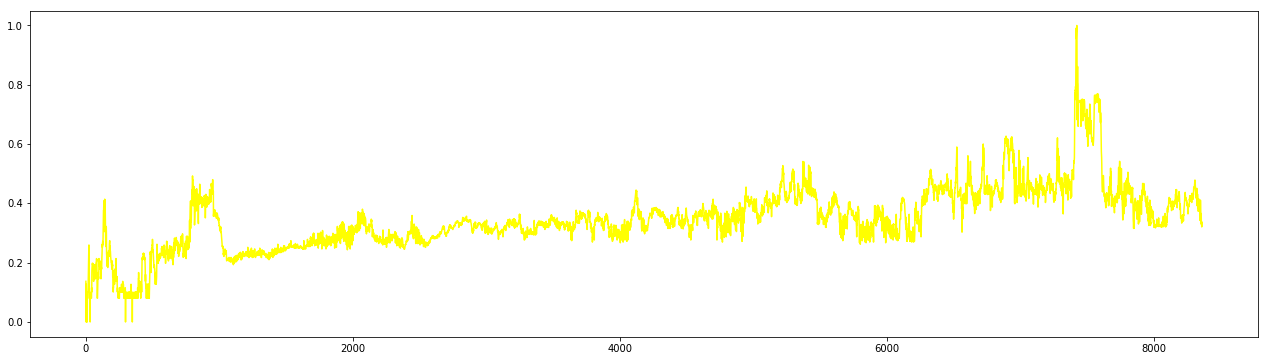

In [118]:
from sklearn.preprocessing import MinMaxScaler
#Normalizamos los datos
transformer = MinMaxScaler().fit(np.array(rai3).reshape(-1, 1))
d = transformer.transform(np.array(rai3).reshape(-1, 1))
plt.figure(figsize=(22,6))
plt.plot(d, color='yellow',label='Raiz Cuadrada');
d = list(d.reshape(1,-1)[0])

## Entrenamiento y Evaluación

Se procede luego a entrenar el modelo, haciendo una busqueda manual de los mejores parametros los cuales nos disminuyan las metricas tomadas, que en este caso fueron el MSE y el MAE, donde apartir de esto tenemos que los siguientes parametros fueron los que mejor se comportaron.

\begin{align}
L = 8 \\
learning rate = 0.0005 \\
max epochs = 1000 \\
\end{align}

Error Medio Cuadratico: 0.00048029096832024454
Error Medio Absoluto: 0.018755565311143474


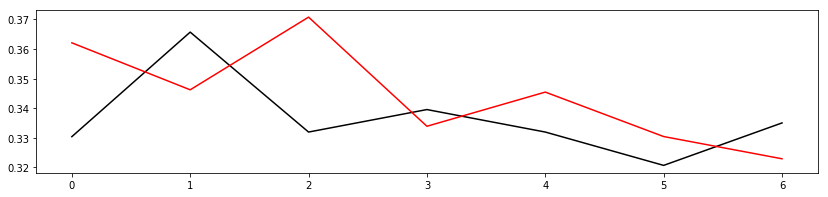

In [114]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline

##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
L = 8

##
## Forma la matriz X
##
X = []
for t in range(L, len(d)):
    X.append(d[t-L:t].copy())


adaline = Adaline(
    learning_rate=0.0005,  # tasa de aprendizaje
    max_epochs=1000,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,    # corrida reproducible
    warm_start=False)    # inicia con pesos aleatorios

errors2, forecasts = adaline.fit(
    X,
    d[L:])

len_test = 7
test = d[len(d)-len_test:len(d)]
predict =forecasts[len(forecasts)-len_test:len(forecasts)]

#Transformada inversa
#predict = np.power(predict,2)
#Desnormalizamos
#predict =  [(i*rango)+min(data) for i in predict]



plt.figure(figsize=(14,3))
plt.plot(test, color='black');
plt.plot(predict, color = 'red');

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, predict)
mse = mean_squared_error(test, predict)

print('Error Medio Cuadratico:',mse)
print('Error Medio Absoluto:',mae)

Se realiza la trasnformada inversa al procesamiento que se le hizo a los datos para corrobar su comportamiento con respecto a la salida original (teniendo en cuenta la conversión con el IPC)

Error Medio Cuadratico: 239.4218359089861
Error Medio Absoluto: 13.012111195059116


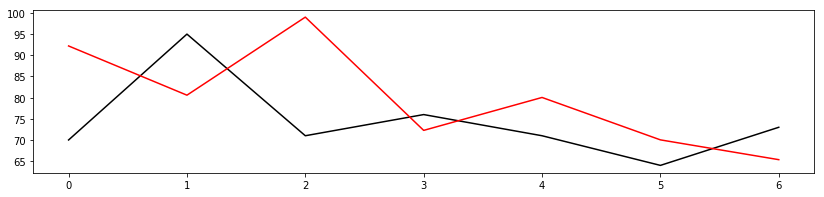

In [117]:
len_test = 7
test = data[len(data)-len_test:len(data)]
predict =forecasts[len(forecasts)-len_test:len(forecasts)]

#Transformada Inversa
predict = transformer.inverse_transform(predict)
predict = np.power(predict,3)


plt.figure(figsize=(14,3))
plt.plot(test, color='black');
plt.plot(predict, color = 'red');

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test, predict)
mse = mean_squared_error(test, predict)

print('Error Medio Cuadratico:',mse)
print('Error Medio Absoluto:',mae)